# IMPORTS:

In [1]:
import numpy as np 
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.efficientnet_v2 import EfficientNetV2B2


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!mkdir /root/.kaggle

In [4]:
!mv /root/kaggle.json /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d bhawks/pokemon-generation-one-22k 

100% 1.95G/1.95G [01:28<00:00, 30.1MB/s]
100% 1.95G/1.95G [01:28<00:00, 23.7MB/s]


In [6]:
!unzip /content/pokemon-generation-one-22k.zip

Streaming output truncated to the last 5000 lines.
  inflating: PokemonData/Rhydon/Rhydon71.jpg  
  inflating: PokemonData/Rhydon/Rhydon72.jpg  
  inflating: PokemonData/Rhydon/Rhydon8.jpg  
  inflating: PokemonData/Rhydon/Rhydon9.jpg  
  inflating: PokemonData/Rhydon/a07e3279dad944b2a2b7dde9c3ac7b86.jpg  
  inflating: PokemonData/Rhydon/a1f1aeb89afe4c499046dff0328d2b71.jpg  
  inflating: PokemonData/Rhydon/a6b299486ec44915ad12beb7e6d42d51.jpg  
  inflating: PokemonData/Rhydon/aae92d0b7fa54fef87d13da7413fe6ac.jpg  
  inflating: PokemonData/Rhydon/ada7861f763a4db8b6c064484f4ca7a6.jpg  
  inflating: PokemonData/Rhydon/b020d00bdb41431ebb339bf81cc08d5f.jpg  
  inflating: PokemonData/Rhydon/b0794caefb6f460c9e5b62fcd7d7dc7f.jpg  
  inflating: PokemonData/Rhydon/b224a248a1e04d09a0b356a00d47e3ca.jpg  
  inflating: PokemonData/Rhydon/b8a67288ddee49b2bdbb1ec323106611.jpg  
  inflating: PokemonData/Rhydon/bc03e7ac94aa417eb11861723a9389c5.jpg  
  inflating: PokemonData/Rhydon/c579ed737b8c4f7f92bb6

In [7]:
img_height = 224
img_width = 224
batch_size=32
data_dir= '/content/PokemonData/'

# LOADING DATA:

In [8]:
train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  label_mode='categorical',
  shuffle=True,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22623 files belonging to 151 classes.
Using 18099 files for training.


In [9]:
val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  label_mode='categorical',
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22623 files belonging to 151 classes.
Using 4524 files for validation.


# Visualizing a few examples

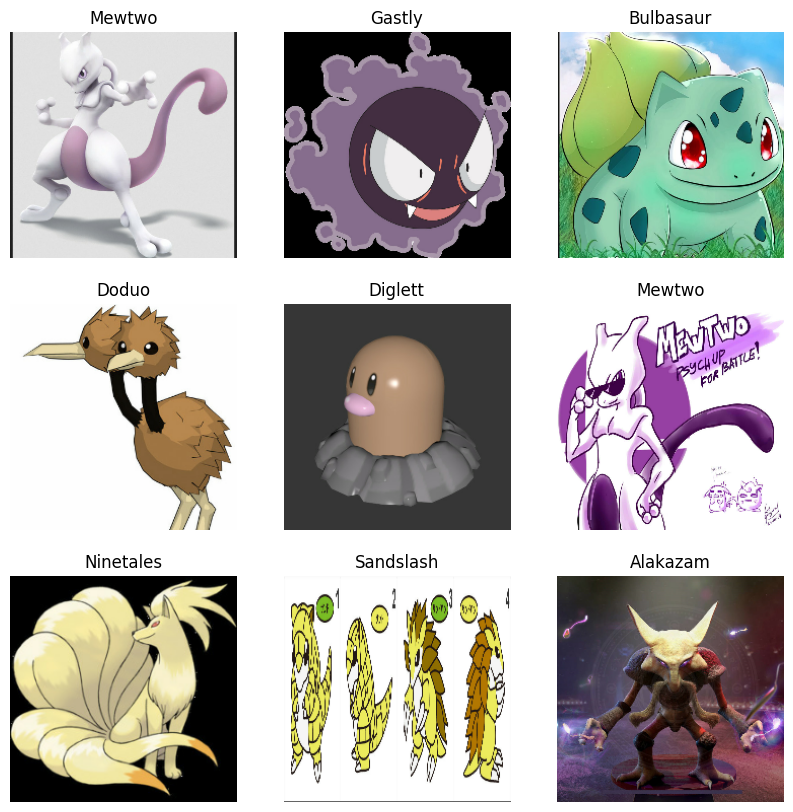

In [10]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

# Modeling 

In [11]:
def transfer_learning(model, number_classes, learning_rate):
  for i in model.layers:
    i.trainable = False
  x=keras.layers.Flatten()(model.output)
  pred=tf.keras.layers.Dense(number_classes, activation='softmax')(x)
  model=tf.keras.Model(inputs=model.input, outputs=pred)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Precision(), keras.metrics.Recall()])
  return model

 #### VGG16

In [12]:
vgg=VGG16(input_shape=(224,224,3),weights='imagenet',include_top=False)
vgg = transfer_learning(vgg, 151, 0.0001)

58889256/58889256 [==============================] - 2s 0us/step


 #### EfficientNetv2

In [13]:
eff_net=EfficientNetV2B2(input_shape=(224,224,3),weights='imagenet',include_top=False)
eff_net = transfer_learning(eff_net, 151, 0.001)

35839040/35839040 [==============================] - 2s 0us/step


# Training the models

In [14]:
vgg.summary(), eff_net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

(None, None)

In [15]:
history_vgg=vgg.fit(train_ds,validation_data=val_ds,epochs=6)

Epoch 1/6
566/566 [==============================] - 118s 180ms/step - loss: 17.0151 - categorical_accuracy: 0.3690 - precision: 0.3774 - recall: 0.3673 - val_loss: 10.5898 - val_categorical_accuracy: 0.5387 - val_precision: 0.5449 - val_recall: 0.5365
Epoch 2/6
566/566 [==============================] - 98s 171ms/step - loss: 2.0287 - categorical_accuracy: 0.8557 - precision: 0.8620 - recall: 0.8542 - val_loss: 10.0005 - val_categorical_accuracy: 0.5798 - val_precision: 0.5876 - val_recall: 0.5780
Epoch 3/6
566/566 [==============================] - 99s 173ms/step - loss: 0.9341 - categorical_accuracy: 0.9428 - precision: 0.9452 - recall: 0.9418 - val_loss: 10.1077 - val_categorical_accuracy: 0.5902 - val_precision: 0.5968 - val_recall: 0.5886
Epoch 4/6
566/566 [==============================] - 99s 173ms/step - loss: 0.8589 - categorical_accuracy: 0.9602 - precision: 0.9612 - recall: 0.9597 - val_loss: 10.2478 - val_categorical_accuracy: 0.5975 - val_precision: 0.6035 - val_recall: 0

In [16]:
history_eff=eff_net.fit(train_ds,validation_data=val_ds,epochs=6)

Epoch 1/6
566/566 [==============================] - 106s 167ms/step - loss: 8.3765 - categorical_accuracy: 0.5428 - precision_1: 0.5604 - recall_1: 0.5399 - val_loss: 7.1884 - val_categorical_accuracy: 0.6830 - val_precision_1: 0.6885 - val_recall_1: 0.6819
Epoch 2/6
566/566 [==============================] - 92s 161ms/step - loss: 2.4713 - categorical_accuracy: 0.8807 - precision_1: 0.8826 - recall_1: 0.8803 - val_loss: 9.2877 - val_categorical_accuracy: 0.6837 - val_precision_1: 0.6875 - val_recall_1: 0.6832
Epoch 3/6
566/566 [==============================] - 92s 161ms/step - loss: 2.3456 - categorical_accuracy: 0.9060 - precision_1: 0.9064 - recall_1: 0.9057 - val_loss: 10.1354 - val_categorical_accuracy: 0.6945 - val_precision_1: 0.6968 - val_recall_1: 0.6939
Epoch 4/6
566/566 [==============================] - 92s 161ms/step - loss: 2.1600 - categorical_accuracy: 0.9210 - precision_1: 0.9218 - recall_1: 0.9209 - val_loss: 11.9764 - val_categorical_accuracy: 0.6989 - val_precisio

# Evaluation

In [18]:
def plot_results(history):
  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(6)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

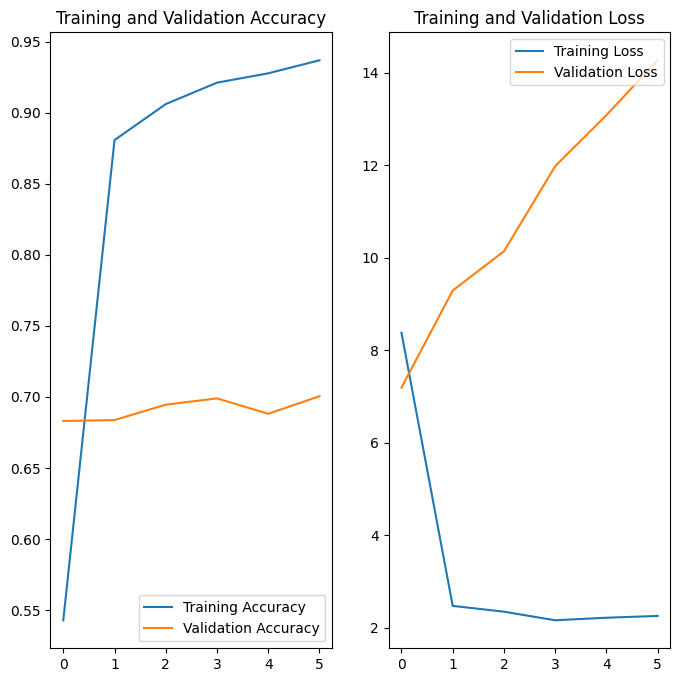

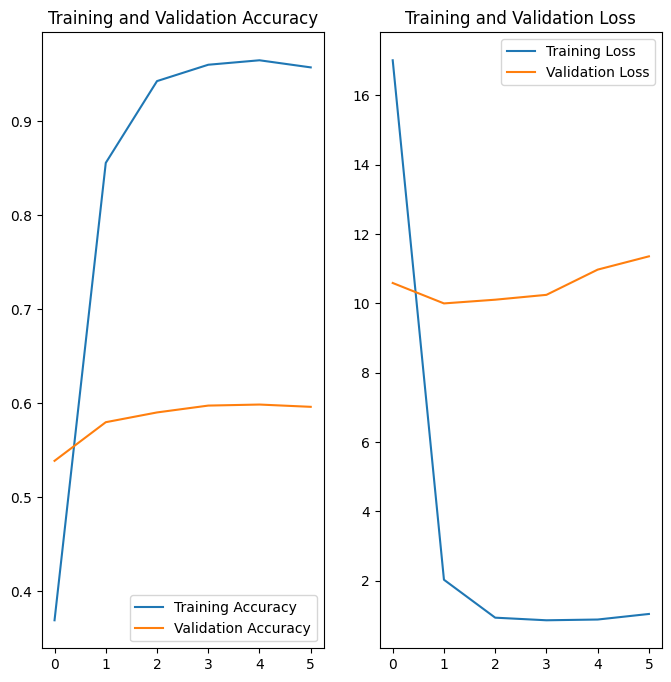

In [19]:
plot_results(history_eff)
plot_results(history_vgg)

# Predict

In [20]:
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(model, image_path):
  img = load_img(image_path, target_size=(img_width, img_height))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  preds = model.predict(images, batch_size=10)
  return preds

In [22]:
predict_image(eff_net, '/content/PokemonData/Rhydon/Rhydon72.jpg')

1/1 [==============================] - 6s 6s/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]], dtype=float32)